### **1. Importer les bibliothèques**

In [1]:
!pip install findspark

In [2]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 43.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=9e7d6759060e155799f29bd8e4bbfbdc26d43bc6f251cf9c272e2b29cc221a11
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [3]:
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType

from sklearn.decomposition import PCA

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

#import standard
import numpy as np
import pandas as pd
from pandas import DataFrame
import cv2
import matplotlib.pyplot as plt


In [4]:
# create a spark session
spark=SparkSession.builder.getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
img_path = '/content/drive/MyDrive/brainhemorrhage'
# Reading dataset 
images = spark.read.format("image")\
.option("pathGlobFilter", "*.jpg")\
.option("recursiveFileLookup", "true").load(img_path) 

### **2. Image preprocessing** 

In [ ]:
def preprocess_image(data):
    img_rgb = np.array(data).reshape(512,512,3)
    image_blur = cv2.GaussianBlur(img_rgb, (3, 3), 0)#Gaussian Blurring the image makes any image smooth and remove the noises
    image_resize = cv2.resize(image_blur, (224, 224))#change the width and height of the image
    image_retour = cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB)#BGR image is converted to RGB
    image_flatten = image_retour.flatten()
    image_bytes = image_flatten.tobytes()
    return image_bytes
    
preprocess_imageUDF = udf(preprocess_image, BinaryType())

df_preprocess = images.withColumn("preprocess_data", preprocess_imageUDF("image.data"))

In [ ]:
df_preprocess.show()

+--------------------+--------------------+
|               image|     preprocess_data|
+--------------------+--------------------+
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 01 01 0...|
|{file:///content/...|[01 01 01 

### **3. Visualisation des images** 

In [ ]:
img_preprocess = df_preprocess.select("preprocess_data").take(100)    

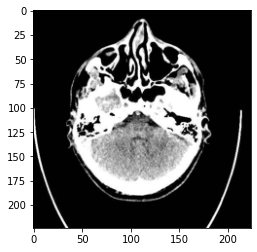

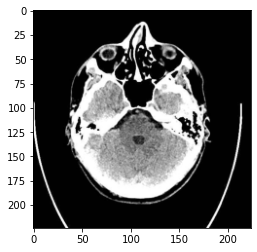

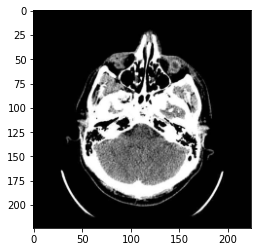

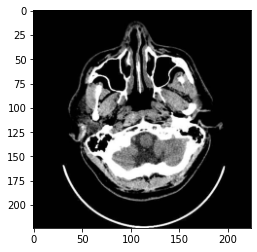

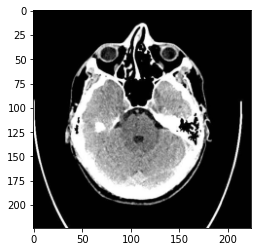

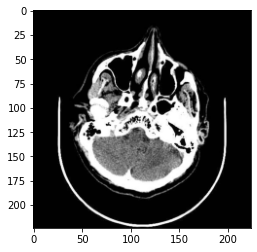

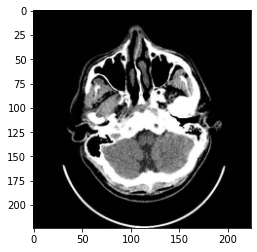

In [ ]:
for i in [1,50,51,52,54,99,80]:
  img_preprocess1 = np.array(img_preprocess[i]).reshape(224,224,3)

  plt.figure(figsize=(4, 4))
  plt.imshow(img_preprocess1)
  plt.show() 

### **4. Extraction des features**

In [ ]:
img_preprocess2 = df_preprocess.select("preprocess_data").take(2453) 

In [ ]:
#utilisation transfer learning pour extraction features 
#remove the output layer
resnet= ResNet50()
model=Model(inputs=resnet.inputs, outputs=resnet.layers[-2].output)

bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

#declaring functions to execute on the worker nodes of the Spark cluster

def model_fn():
  
  #Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
  
  modelvgg = ResNet50(weights=None)
  model=Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
  model.set_weights(bc_model_weights.value)
  return model 


def extract_features(filename):
    mod = model_fn()
    lis=[]
    for i in range(2453):
        # Loading and resizing image
        image=np.array(filename[i]).reshape(224,224,3)
        # Convert the image pixels to a numpy array
        image = img_to_array(image)
        # Reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Pass image into model to get encoded features
        features = mod.predict(image)  
        feat=features.flatten()
        lis.append(feat)
    return lis

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
df_features=extract_features(img_preprocess2) 

In [ ]:
type(df_features)

list

In [ ]:
df=pd.Series(df_features)
print(df) 

0       [0.10699006, 0.24520664, 0.0, 0.10917788, 0.01...
1       [0.043441117, 0.87038946, 0.006225489, 0.51656...
2       [0.016686866, 1.2296714, 0.017769517, 0.788340...
3       [0.008765879, 1.6609662, 0.11624858, 0.8229749...
4       [0.0, 1.1270702, 0.009255897, 0.4293678, 0.179...
                              ...                        
2448    [0.5083013, 1.2778559, 0.5541998, 0.49187773, ...
2449    [4.604477e-05, 3.2183678, 0.9616611, 0.0022727...
2450    [0.44076422, 1.1502709, 0.5928606, 0.38717255,...
2451    [0.3411455, 1.2304583, 0.028453304, 0.099392, ...
2452    [0.64562684, 0.7698637, 0.47248536, 0.27956697...
Length: 2453, dtype: object


In [ ]:
list=[]
for i in range(2453):
  df1 = df[i].astype(float) 
  list.append(df1)
   

In [ ]:
df_features=pd.DataFrame(list)
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.106990,0.245207,0.000000,0.109178,0.012106,0.000000,1.748170,0.032364,0.032675,0.065531,...,0.000472,0.267974,0.561750,0.0,0.072046,0.608759,0.000000,1.373603,0.249528,0.545409
1,0.043441,0.870389,0.006225,0.516562,0.222042,0.994114,3.293071,0.026245,0.118073,0.018098,...,0.096172,0.162659,1.578747,0.0,0.246255,0.205252,0.000000,0.740869,0.130242,0.978222
2,0.016687,1.229671,0.017770,0.788341,0.178483,1.037326,3.288777,0.002983,0.200805,0.000000,...,0.001344,0.356982,1.328483,0.0,0.459124,0.256833,0.000855,0.779599,0.164180,0.982594
3,0.008766,1.660966,0.116249,0.822975,0.331067,0.537143,3.055477,0.016781,0.287413,0.000000,...,0.006970,0.430859,1.159617,0.0,0.494387,0.349292,0.000000,0.761555,0.166335,1.048392
4,0.000000,1.127070,0.009256,0.429368,0.179854,0.844577,3.114247,0.009712,0.131152,0.000000,...,0.002061,0.148775,1.290474,0.0,0.316482,0.072499,0.000000,0.756061,0.054361,0.859923


In [ ]:
df_pca = PCA(n_components=4)
df_pca.fit(df_features) 

PCA(n_components=4)

In [ ]:
columns = ['pca_%i' % i for i in range(4)]
df_pca = DataFrame(df_pca.transform(df_features), columns=columns, index=df_features.index)
df_pca.head()  

,pca_0,pca_1,pca_2,pca_3
0,-5.543013,-9.917105,4.588297,0.496401
1,-8.467869,-0.704709,-3.014686,-9.461626
2,-6.389877,-0.257193,-1.094750,-11.028096
3,-8.370157,-0.661658,-0.884369,-12.033973
4,-7.766966,1.258590,-1.990586,-10.823721
